Чаусов Д.Н.

# 0. Импорт библиотек

In [4]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from scipy.stats.stats import spearmanr
from scipy.stats.stats import kendalltau
from scipy.sparse import vstack, hstack, csc_matrix
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import OneHotEncoder

from data_processing import has_teamMembers_and_mask, dict_to_df, type_tourn

from base_model import questions_and_players, create_dataset, train_model_lr

from my_class import Tournament

# 1. Прочитайте и проанализируйте данные

In [5]:
players = pd.read_pickle('players.pkl')
tournaments = pd.read_pickle('tournaments.pkl')
results = pd.read_pickle('results.pkl')

**Выделим train и test, и приведем к удобному виду**

In [6]:
tournaments_df = dict_to_df(tournaments)
tournaments_df.head()

,dateEnd,dateStart,name,questionQty,season,synchData,type,year,month
id,,,,,,,,,
1,2003-07-26 20:00:00+00:00,2003-07-24 20:00:00+00:00,Чемпионат Южного Кавказа,None,/seasons/1,None,2,2003,7
2,2003-08-08 20:00:00+00:00,2003-08-08 20:00:00+00:00,Летние зори,None,/seasons/1,None,2,2003,8
3,2003-11-23 21:00:00+00:00,2003-11-21 21:00:00+00:00,Турнир в Ижевске,None,/seasons/2,None,2,2003,11
4,2003-10-11 20:00:00+00:00,2003-10-10 20:00:00+00:00,Чемпионат Украины. Переходной этап,None,/seasons/2,None,2,2003,10
5,2003-10-12 20:00:00+00:00,2003-10-09 20:00:00+00:00,Бостонское чаепитие,None,/seasons/2,None,2,2003,10


**тренировочный набор - турниры с dateStart из 2019 года; тестовый — турниры с dateStart из 2020 года.**

In [7]:
tournaments_df = tournaments_df[tournaments_df.year >= 2019]

# Добавим общее количество вопросов
tournaments_df['total_questions'] = tournaments_df.questionQty.apply(lambda x: sum((v for k,v in x.items())))
tournaments_df.head()

,dateEnd,dateStart,name,questionQty,season,synchData,type,year,month,total_questions
id,,,,,,,,,,
4628,2020-12-30 13:00:00+00:00,2020-12-30 13:00:00+00:00,Семь сорок,"{'1': 12, '2': 12, '3': 12}",None,{'dateRequestsAllowedTo': '2020-12-30T23:55:00...,3,2020,12,36
4772,2019-01-09 16:00:00+00:00,2019-01-05 16:00:00+00:00,Синхрон северных стран. Зимний выпуск,"{'1': 12, '2': 12, '3': 12}",/seasons/52,{'dateRequestsAllowedTo': '2019-01-09T23:59:59...,3,2019,1,36
4957,2020-02-27 20:00:00+00:00,2020-02-20 21:00:00+00:00,Синхрон Биркиркары,"{'1': 13, '2': 13, '3': 13}",/seasons/53,{'dateRequestsAllowedTo': '2020-02-27T18:00:00...,3,2020,2,39
4973,2019-01-29 16:00:00+00:00,2019-01-25 16:05:00+00:00,Балтийский Берег. 3 игра,"{'1': 12, '2': 12, '3': 12}",/seasons/52,{'dateRequestsAllowedTo': '2019-01-28T23:59:59...,3,2019,1,36
4974,2019-03-05 16:00:00+00:00,2019-03-01 16:05:00+00:00,Балтийский Берег. 4 игра,"{'1': 12, '2': 12, '3': 12}",/seasons/52,{'dateRequestsAllowedTo': '2019-03-04T23:59:59...,3,2019,3,36


In [8]:
train_tournaments = tournaments_df[tournaments_df.year == 2019]
test_tournaments = tournaments_df[tournaments_df.year == 2020]
print(f'Турниров в train: {len(train_tournaments)}')
print(f'Турниров в test: {len(test_tournaments)}')
print(f'Всего вопросов в train {train_tournaments.total_questions.sum()}')
print(f'Всего вопросов в test {test_tournaments.total_questions.sum()}')
pd.to_pickle(train_tournaments, 'train_tournaments.pkl')

Турниров в train: 689
Турниров в test: 416
Всего вопросов в train 34161
Всего вопросов в test 18135


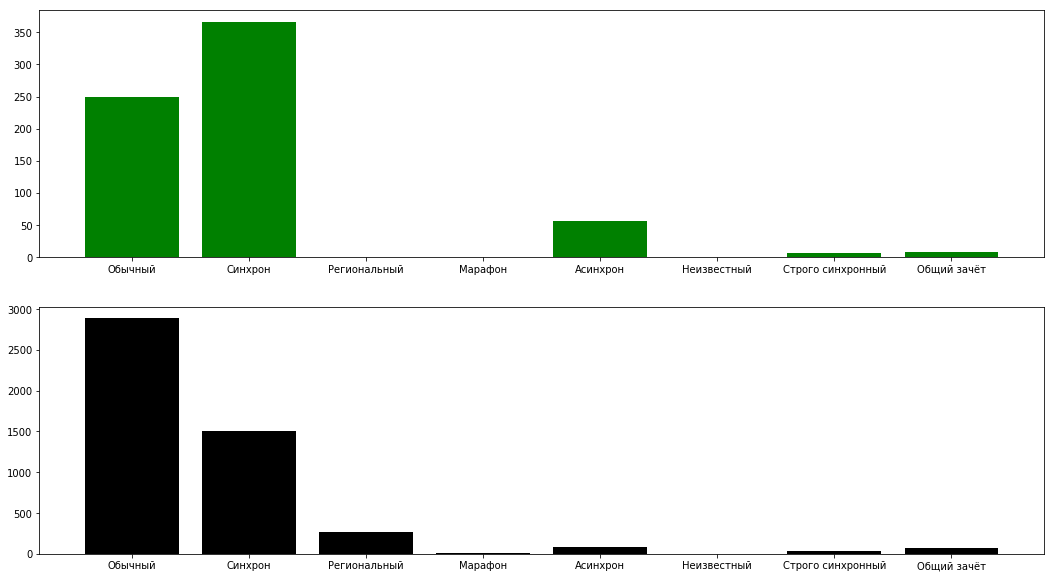

In [9]:
type_tourn(results, tournaments)

# 2. Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков

### Сложность вопросов и информация об ответах игроков

In [10]:
questions, players_result = questions_and_players(train_tournaments, results)

In [11]:
questions.head()

,canceled,difficulty,id,negative,positive,question,tournament
0,0,0.116883,4772_0,27,204,0,4772
1,0,0.220779,4772_1,51,180,1,4772
2,0,0.554113,4772_2,128,103,2,4772
3,0,0.480519,4772_3,111,120,3,4772
4,0,0.121212,4772_4,28,203,4,4772


In [12]:
players_result.head()

,answered,not_answered,player_id,question
0,1,0,6212,4772_0
1,1,0,6212,4772_1
2,1,0,6212,4772_2
3,1,0,6212,4772_3
4,1,0,6212,4772_4


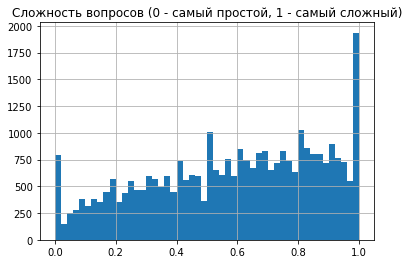

In [13]:
# Оставляем только не исключенные вопросы
questions = questions[questions.canceled==0]

questions.difficulty.hist(bins=50)
plt.title('Сложность вопросов (0 - самый простой, 1 - самый сложный)')
plt.show()

### Распределение турниров по сложности вопросов

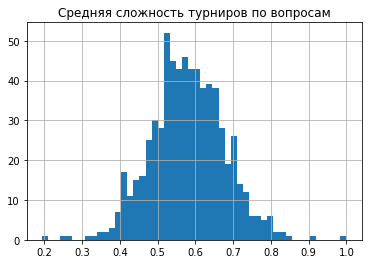

In [14]:
questions.groupby(['tournament']).agg({'difficulty': 'mean'}).hist(bins=50)
plt.title('Средняя сложность турниров по вопросам')
plt.show()

**Разделим вопросы на несколько уровней сложности и по ним будем строить предсказания рейтинга**

In [15]:
levels = 5
quantiles = [questions.difficulty.quantile(i/levels) for i in range(1, levels + 1)]
questions['level'] = 0
for i in range(levels, 0, -1):
    questions.loc[questions.difficulty <= quantiles[i - 1], 'level'] = i

Для каждого игрока признаками будет:

    - количество вопросов каждой сложности, на которые он ответил правильно
    - количество вопросов каждой сложности, на котороые он не ответил правильно

In [16]:
player_result = pd.merge(players_result, questions, how='left', left_on='question', right_on='id')
player_result.head()

,answered,not_answered,player_id,question_x,canceled,difficulty,id,negative,positive,question_y,tournament,level
0,1,0,6212,4772_0,0.0,0.116883,4772_0,27.0,204.0,0.0,4772.0,1.0
1,1,0,6212,4772_1,0.0,0.220779,4772_1,51.0,180.0,1.0,4772.0,1.0
2,1,0,6212,4772_2,0.0,0.554113,4772_2,128.0,103.0,2.0,4772.0,3.0
3,1,0,6212,4772_3,0.0,0.480519,4772_3,111.0,120.0,3.0,4772.0,2.0
4,1,0,6212,4772_4,0.0,0.121212,4772_4,28.0,203.0,4.0,4772.0,1.0


In [17]:
player_result_grouped = player_result.groupby(['player_id', 'level']).agg({'answered': 'sum', 'not_answered': 'sum'})
player_result_grouped['p'] = player_result_grouped['answered'] / (player_result_grouped['answered'] + player_result_grouped['not_answered'])
player_result_grouped['n'] = player_result_grouped['answered'] + player_result_grouped['not_answered']
player_result_grouped = player_result_grouped[['n', 'p']].unstack(-1)
player_result_grouped

n                                     p                      \
level        1.0    2.0    3.0    4.0    5.0       1.0       2.0       3.0   
player_id                                                                    
15         100.0  141.0  148.0  116.0   55.0  0.710000  0.468085  0.290541   
16          44.0   50.0   74.0   37.0   29.0  0.954545  0.760000  0.567568   
23           7.0    9.0    9.0   10.0    1.0  1.000000  0.666667  0.333333   
31         150.0  185.0  216.0  185.0  129.0  0.860000  0.621622  0.402778   
35         190.0  196.0  195.0  140.0   58.0  0.836842  0.658163  0.435897   
38          49.0  129.0  130.0  116.0   47.0  0.530612  0.240310  0.169231   
47          85.0  104.0  115.0  103.0   90.0  0.941176  0.778846  0.521739   
59          87.0  104.0  139.0   93.0   87.0  0.839080  0.500000  0.366906   
65          35.0   69.0   64.0   60.0   23.0  0.771429  0.449275  0.218750   
79         188.0  276.0  312.0  236.0  133.0  0.803191  0.565217  0.349359   
80         132.0  180.0  184.0  172.0  146.0  0.931818  0.772222  0.559783   
82         260.0  359.0  363.0  296.0  177.0  0.853846  0.526462  0.294766   
98          19.0   30.0   35.0   24.0    7.0  0.894737  0.366667  0.285714   
112         16.0   27.0   25.0   41.0   47.0  0.750000  0.370370  0.400000   
113         59.0   43.0   44.0   47.0   31.0  0.813559  0.488372  0.250000   
117        354.0  484.0  445.0  393.0  445.0  0.920904  0.768595  0.617978   
119        105.0  117.0  113.0   89.0   50.0  0.809524  0.623932  0.407080   
133        151.0  169.0  180.0  184.0  103.0  0.940397  0.816568  0.566667   
136         44.0   67.0   72.0   48.0   19.0  0.863636  0.462687  0.319444   
144        175.0  242.0  257.0  258.0  234.0  0.931429  0.785124  0.653696   
150         79.0   92.0   83.0   77.0   40.0  0.936709  0.804348  0.674699   
153         29.0   38.0   50.0   73.0   65.0  0.862069  0.631579  0.620000   
157         15.0   13.0    4.0    2.0    2.0  0.800000  0.538462  0.500000   
160          2.0    8.0   13.0    8.0    6.0  1.000000  1.000000  0.538462   
176        396.0  488.0  475.0  427.0  279.0  0.924242  0.809426  0.665263   
178        174.0  308.0  312.0  324.0  251.0  0.879310  0.655844  0.487179   
182        229.0  320.0  315.0  309.0  231.0  0.890830  0.650000  0.444444   
196         36.0   32.0   56.0   43.0   37.0  0.833333  0.531250  0.428571   
223         34.0   34.0   37.0   22.0    7.0  0.852941  0.647059  0.594595   
230         76.0  108.0  113.0   96.0   49.0  0.881579  0.787037  0.548673   
...          ...    ...    ...    ...    ...       ...       ...       ...   
224051       NaN    4.0   16.0   16.0    NaN       NaN  0.750000  0.187500   
224052       NaN    4.0   16.0   16.0    NaN       NaN  0.750000  0.187500   
224059       NaN    4.0   16.0   16.0    NaN       NaN  0.500000  0.250000   
224081       NaN    4.0   16.0   16.0    NaN       NaN  0.500000  0.125000   
224082       NaN    4.0   16.0   16.0    NaN       NaN  0.500000  0.187500   
224083       NaN    4.0   16.0   16.0    NaN       NaN  0.500000  0.187500   
224084       NaN    4.0   16.0   16.0    NaN       NaN  0.500000  0.187500   
224085       NaN    4.0   16.0   16.0    NaN       NaN  0.500000  0.187500   
224086       NaN    4.0   16.0   16.0    NaN       NaN  0.250000  0.187500   
224097       1.0    7.0   11.0   14.0    3.0  0.000000  0.285714  0.272727   
224098       1.0    7.0   11.0   14.0    3.0  0.000000  0.285714  0.272727   
224099       1.0    7.0   11.0   14.0    3.0  0.000000  0.285714  0.272727   
224104       NaN    4.0   16.0   16.0    NaN       NaN  1.000000  0.687500   
224193       8.0   19.0   16.0   18.0   11.0  0.875000  0.578947  0.375000   
224236       3.0   12.0    9.0    5.0    7.0  0.666667  0.500000  0.111111   
224278       4.0    8.0    9.0    8.0    7.0  0.250000  0.125000  0.000000   
224279       4.0    8.0    9.0    8.0    7.0  0.250000  0.125000  0.000000   
224280       4.0    8.0    9.0    8.0

   - Nan - заполним медианами в p и 0 в n
   - 0.0 в вероятностях правильного ответа, где количество вопросов было меньше 5. Для вопросов со сложностью меньше 5 заменим на медиану или на вероятность для более низкой сложности - смотря что ниже.
   - 0.0 во всех остальных случаях заменим на маленькую вероятность.

In [18]:
player_result_grouped['n'] = player_result_grouped['n'].fillna(0)
player_result_grouped['p'] = player_result_grouped['p'].fillna(player_result_grouped['p'].median())

In [19]:
median_p = {}
for i in range(1, levels + 1):
    median_p[i] = player_result_grouped.loc[:, ('p', i)].median()
    print(f"Median for difficulty {i}: {median_p[i]}")

Median for difficulty 1: 0.7857142857142857
Median for difficulty 2: 0.4876218776116631
Median for difficulty 3: 0.2777777777777778
Median for difficulty 4: 0.1276595744680851
Median for difficulty 5: 0.0


In [20]:
dfclty = 1
player_result_grouped.loc[
    (player_result_grouped[('p', dfclty)]==0.0) & (player_result_grouped[('n', dfclty)] < 5),
                          ('p', dfclty)] = player_result_grouped.loc[:, ('p', dfclty)].median()

In [21]:
for dfclty in range(2, levels):
# Меняем на вероятность, которая соответсвует меньшей сложности
    low_difficulty = player_result_grouped.loc[(player_result_grouped[('p', dfclty)]==0.0) & \
                                               (player_result_grouped[('n', dfclty)] < 5),
                                               ('p', dfclty - 1)] < median_p[dfclty]
    low_difficulty = low_difficulty[low_difficulty]
    player_result_grouped.loc[low_difficulty.index,
                              ('p', dfclty)] = player_result_grouped.loc[low_difficulty.index,
                                                                             ('p', dfclty - 1)]
# Меняем нв вероятность средней сложности
    player_result_grouped.loc[(player_result_grouped[('p', dfclty)]==0.0) & \
                              (player_result_grouped[('n', dfclty)] < 5),
                              ('p', dfclty)] = median_p[dfclty]

In [22]:
min_p = {}
for i in range(1, levels + 1):
    min_p[i] = player_result_grouped.loc[player_result_grouped[('p', i)] > 0, ('p', i)].min()
    print(f"Min for difficulty {i}: {min_p[i]}")

Min for difficulty 1: 0.043478260869565216
Min for difficulty 2: 0.018518518518518517
Min for difficulty 3: 0.011363636363636364
Min for difficulty 4: 0.0058823529411764705
Min for difficulty 5: 0.003389830508474576


In [23]:
for dfclty in range(1, levels):
    player_result_grouped.loc[(player_result_grouped[('p', dfclty)]==0.0),
                              ('p', dfclty)] = min_p[dfclty]

In [24]:
player_result_grouped['total_questions'] = player_result_grouped['n'].sum(axis=1)
player_result_grouped.head().append(player_result_grouped.tail())

n                                     p                      \
level        1.0    2.0    3.0    4.0    5.0       1.0       2.0       3.0   
player_id                                                                    
15         100.0  141.0  148.0  116.0   55.0  0.710000  0.468085  0.290541   
16          44.0   50.0   74.0   37.0   29.0  0.954545  0.760000  0.567568   
23           7.0    9.0    9.0   10.0    1.0  1.000000  0.666667  0.333333   
31         150.0  185.0  216.0  185.0  129.0  0.860000  0.621622  0.402778   
35         190.0  196.0  195.0  140.0   58.0  0.836842  0.658163  0.435897   
224404      18.0   24.0   22.0   21.0   11.0  0.388889  0.416667  0.272727   
224408       2.0   10.0    8.0    4.0   12.0  0.500000  0.300000  0.011364   
224482       2.0   11.0    9.0   10.0    4.0  0.500000  0.181818  0.111111   
224539       6.0    8.0    9.0   11.0   11.0  0.666667  0.500000  0.333333   
224542      15.0    8.0    8.0    3.0    2.0  1.000000  0.875000  0.625000   

                              total_questions  
level           4.0       5.0                  
player_id                                      
15         0.163793  0.054545           560.0  
16         0.189189  0.000000           234.0  
23         0.200000  0.000000            36.0  
31         0.270270  0.038760           865.0  
35         0.242857  0.103448           779.0  
224404     0.238095  0.000000            96.0  
224408     0.127660  0.000000            36.0  
224482     0.005882  0.000000            36.0  
224539     0.090909  0.000000            45.0  
224542     0.127660  0.000000            36.0

**У нас готовы признаки игроков, добавим к ним сложность вопросов и обучим логистическую регрессию**

In [25]:
# del results, players, tournaments, tournaments_df

In [26]:
dataset, min_qty, max_qty = create_dataset(player_result, player_result_grouped)

/home/chausov/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


### Train model

In [27]:
# dataset_sample = dataset.sample(5000000)

model = train_model_lr(dataset)

/home/chausov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 0.7587046


In [28]:
# del dataset

**Для каждого игрока теперь просэмплируем по 20000 вопросов разной сложности и посчитаем для каждого игрока на сколько из них он бы ответил - далее построим рейтинг**

In [29]:
players_total_questions = player_result_grouped.total_questions.copy()
player_result_grouped.drop('total_questions', axis=1, inplace=True)
players_total_questions.head()

player_id
15    560.0
16    234.0
23     36.0
31    865.0
35    779.0
Name: total_questions, dtype: float64

In [30]:
# Из этого распределения будем сэмплировать вопросы:
p_questions = questions.difficulty

sample_size = 20000
q_sample = np.array(p_questions.sample(sample_size)).reshape(-1, 1)

In [31]:
# Проведем нормировку для количества вопросов
for i in range(1, levels + 1):
    player_result_grouped[('n', i)] = (player_result_grouped[('n', i)] - min_qty[-1]) / (max_qty[-1] - min_qty[-1])

In [32]:
players_rating = []
for idx in tqdm.tqdm(player_result_grouped.index):
    player_sample = np.array(player_result_grouped.loc[idx]).reshape(1, -1)
    X = np.hstack([q_sample, np.tile(player_sample, (sample_size, 1))])
    rating = model.predict(X).sum()
    players_rating.append({'id': idx, 'rating': rating})

100%|██████████| 59271/59271 [00:37<00:00, 1576.72it/s]


In [33]:
players_rating = pd.DataFrame(players_rating).sort_values('rating', ascending=False)

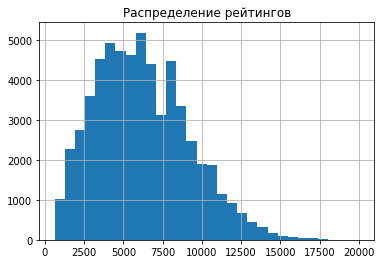

In [34]:
players_rating.rating.hist(bins=30)
plt.title('Распределение рейтингов')
plt.show()

**Лучшие игроки**

In [35]:
players = pd.read_pickle('players.pkl')
players_names = pd.DataFrame([v for k, v in players.items()])
players_names.index = players_names.id
players_names.drop('id', axis=1, inplace=True)
players_names.head(15)

,name,patronymic,surname
id,,,
1,Алексей,None,Абабилов
10,Игорь,,Абалов
11,Наталья,Юрьевна,Абалымова
12,Артур,Евгеньевич,Абальян
13,Эрик,Евгеньевич,Абальян
14,Василий,,Абанин
15,Олег,Игоревич,Абарников
16,Азер,Абасали оглы,Абасалиев
17,А.,В.,Абасев


In [36]:
players_rating.index = players_rating.id
players_rating.drop('id', axis=1, inplace=True)
players_rating = pd.merge(players_rating, 
                          players_names, how='left', left_index=True, right_index=True)
players_rating = pd.merge(players_rating, 
                          players_total_questions, how='left', left_index=True, right_index=True)


In [37]:
players_rating.head(12)

,rating,name,patronymic,surname,total_questions
id,,,,,
36844,20000,Павел,Константинович,Щербина,36.0
171845,18900,Михаил,Владимирович,Завьялов,36.0
216863,18900,Глеб,Юрьевич,Гаврилов,72.0
170977,18900,Давид,Сергеевич,Кан,36.0
180055,18047,Никита,Дмитриевич,Панфилов,72.0
218271,17955,Алексей,Валерьевич,Антонов,72.0
168560,17886,Полина,Дмитриевна,Джегур,36.0
168573,17886,Елизавета,Витальевна,Коваленко,36.0
135951,17886,Артём,Феликсович,Стетой,72.0


**топ-10 игроков, ответивших на более чем 1000 вопросов**

In [38]:
linear_rating = players_rating[players_rating.total_questions > 1000]
linear_rating.head(15)

,rating,name,patronymic,surname,total_questions
id,,,,,
27403,17128,Максим,Михайлович,Руссо,2331.0
28751,17068,Иван,Николаевич,Семушин,3963.0
4270,17066,Александра,Владимировна,Брутер,2881.0
27822,16661,Михаил,Владимирович,Савченков,3449.0
30152,16482,Артём,Сергеевич,Сорожкин,5083.0
30270,16317,Сергей,Леонидович,Спешков,3962.0
87637,15971,Антон,Владимирович,Саксонов,1266.0
56647,15577,Наталья,Евгеньевна,Горелова,2165.0
20691,15542,Станислав,Григорьевич,Мереминский,1656.0


In [39]:
# del questions

# 3. Качество рейтинг-системы оценивается качеством предсказаний результатов турниров.

In [40]:
test_tournaments.head()

,dateEnd,dateStart,name,questionQty,season,synchData,type,year,month,total_questions
id,,,,,,,,,,
4628,2020-12-30 13:00:00+00:00,2020-12-30 13:00:00+00:00,Семь сорок,"{'1': 12, '2': 12, '3': 12}",None,{'dateRequestsAllowedTo': '2020-12-30T23:55:00...,3,2020,12,36
4957,2020-02-27 20:00:00+00:00,2020-02-20 21:00:00+00:00,Синхрон Биркиркары,"{'1': 13, '2': 13, '3': 13}",/seasons/53,{'dateRequestsAllowedTo': '2020-02-27T18:00:00...,3,2020,2,39
5151,2020-08-05 11:00:00+00:00,2020-08-01 11:00:00+00:00,Яровой,"{'1': 12, '2': 12, '3': 12}",/seasons/53,{'dateRequestsAllowedTo': '2020-07-24T23:59:59...,3,2020,8,36
5414,2020-01-10 16:00:00+00:00,2020-01-03 16:00:00+00:00,Синхрон северных стран,"{'1': 12, '2': 12, '3': 12}",/seasons/53,{'dateRequestsAllowedTo': '2020-01-10T23:59:00...,3,2020,1,36
5477,2020-04-30 16:00:00+00:00,2020-04-18 16:00:00+00:00,Онлайн: Синхрон Урюбджирова,"{'1': 12, '2': 12, '3': 12}",/seasons/53,{'dateRequestsAllowedTo': '2020-04-30T23:55:00...,8,2020,4,36


In [41]:
results = pd.read_pickle('results.pkl')
tmp_tournament = Tournament(5477, results, test_tournaments, model, p_questions, player_result_grouped)
prediction, ground_true = tmp_tournament.simulate()

In [42]:
spearman_correlations = []
kendall_correlations = []
for idx in tqdm.tqdm(test_tournaments.index):
    if results[idx]:
        tournament = Tournament(idx, results, test_tournaments, model, p_questions, player_result_grouped)
        prediction, ground_true = tournament.simulate()
        if prediction is None or ground_true is None:
            continue
        spearman_corr = spearmanr(prediction, ground_true)[0]
        spearman_correlations.append(spearman_corr)
        kendall_corr = kendalltau(prediction, ground_true)[0]
        kendall_correlations.append(kendall_corr)

100%|██████████| 416/416 [01:03<00:00,  6.57it/s]


In [43]:
print(f'Корреляция Спирмена: {np.mean([t for t in spearman_correlations if np.isfinite(t)]):0.2f}')
print(f'Корреляция Кендалла: {np.mean([t for t in kendall_correlations if np.isfinite(t)]):0.2f}')

Корреляция Спирмена: 0.71
Корреляция Кендалла: 0.55


# 4. Теперь главное: ЧГК — это всё-таки командная игра.

In [44]:
def get_players_and_questions_qty(results_data, tournaments):
    players = set()
    for idx in tournaments.index:
        for team in results_data[idx]:
            team_id = team['team']['id']
            for player in team['teamMembers']:
                player_id = player['player']['id']
                players.add(player_id)
    return len(players), tournaments.total_questions.sum()

In [45]:
total_players, total_questions = get_players_and_questions_qty(results, train_tournaments)
print(f'В train всего {total_players} игроков')
print(f'В train всего {total_questions} вопросов')

В train всего 59394 игроков
В train всего 34161 вопросов


Применение EM алгоритма

- Мы не можем зафиксировать команды, так как игрок может произвольно менять команду от турнира к турниру, поэтому далее объект "команда" - это вектор из 0 и 1 размера 59394, в котором 1 означает, что игрок входит в команду, а 0 - не входит.

- Мы наблюдаем ответ команды в целом на вопрос, пусть $x_{ti} = 1$ означает что команда $t$ ответила на вопрос $q$, и $x_{ti} = 0$ означает что команда $t$ не ответила на вопрос $i$

- Как показали ранее мы моделируем ответ игрока $i$ на вопрос $j$ как $\sigma(p_{i} + q_{j} + const)$

- Обозначим скрытые переменные $z_{ij}$ - ответ игрока $i$ на вопрос $j$ - мы не знаем как отвечал конкретный игрок внутри команды, но можем попробовать связать их $z_{ij}$ с $x_{tj}$ - ответом команды на копрос $j$:


1. Если команда $t$ не ответила на вопрос $i$, то считаем, что ни один из игроков не ответил на вопрос (случай, когда кто-то знал правильный ответ, но команда выбрала другой ответ - не рассматриваем), т.е. $z_{ij} = 0 \forall j \in t$
2. Если команда $t$ ответила на вопрос $i$, то считаем, что как существует как минимум 1 игрок из этой команды, который знал правильный ответ: $\exists j \in t: z_{ij} = 1$

### Собственно EM алгоритм:

- нулевой шаг: Обучим логистические регрессии  $x_{tj} \sim \sigma(p_{i} + q_{j} + const) \forall i \in t$ и найдем начальные значения $p_{i}$ и $q_{j}$ - заодно проверим насколько такие решения отличаются от бейзлайна, возможно это и стоило считать бейзлайном :-)

- E-шаг - найдем мат. ожидания $z_{i}{j}$:
$\mathbf{E}z_{ij} = 
\begin{cases}
0, \forall i \in t, \text{если команда t не ответила на вопрос j}\\
\frac{\sigma(p_{i} + q_{j} + const)}{1 - \prod_{k \in t}(1 - \sigma(p_{k} + q_{j} + const))}, \text{если команда t ответила на вопрос j - далее покажу как пришел к этому}\\
\end{cases}$

- M-шаг - с новыми $\mathbf{E}z_{ij}$ обновляем $p_{i}$ и $q_{j}$, то есть находим оптимальные значения для задачи: $\mathbf{E}z_{ij} \sim \sigma(p_{i} + q_{j} + const)$

### Вывод E-шага:

Если команда ответила на вопрос правильно, то хотя бы один игрок смог ответить правильно.
Пусть у нас в команде $m$ игроков и событие, что они дали правильный ответ на текущий вопрос с текущими $p_{i}$ и $q_{j}$ - $A_{i} \forall i \leqslant m$

$p(A_{i}) = \sigma(p_{i} + q_{j} + const) \forall i \leqslant m$

Событие $B$ - это команда ответила правильно, вероятность этого события $P(B) = 1 - \prod_{i \leqslant m}(1 - p(A_i))$ - то есть вероятность того, что хотя бы один из игроков дал правильный ответ.

В E-шаге нам нужно вычислить $\mathbf{E}(z_{ij})$ то есть мат ожидание вероятности того, что игрок ответил правильно, при условии, что команда ответила правильно, то есть: $P(z_{ij}|x_{tj})$

Применим теорему Байеса:

$P(z_{ij}|x_{tj}=1) = P(A_i|B) = \frac{P(B|A_i)P(A_i)}{P(B)} = $ 

учтем, что вероятность $P(B|A_i)=1$ т.к. если игрок дал правильный ответ, то и команда дала правильный ответ

$= \frac{P(A_i)}{P(B)} = \frac{\sigma(p_{i} + q_{j} + const)}{1 - \prod_{k \leqslant m}(1 - p(A_k))} = \frac{\sigma(p_{i} + q_{j} + const)}{1 - \prod_{k \leqslant m}(1 - \sigma(p_{k} + q_{j} + const))}$

**Соберем id всех игроков и всех вопросов в результатах турниров за 2019 год**

In [46]:
player_ids = set()
train_questions_qty = 0

for idx in tqdm.tqdm(train_tournaments.index):
    tournament_questions = train_tournaments.loc[idx].total_questions
    for team in results[idx]:
        if 'mask' not in team:
            continue
        mask = team['mask']
        if mask is None:
            continue
        canceled = np.sum([1 if a=='X' else 0 for a in mask])
        for player in team['teamMembers']:
            player_ids.add(player['player']['id'])

    train_questions_qty += (tournament_questions - canceled)
    
player_ids = np.array(list(player_ids)).reshape(-1, 1)
print(f'Всего игроков: {(player_ids.shape[0])}')
print(f'Всего вопросов: {train_questions_qty} - исключили вопросы, которые были отменены/сняты')

100%|██████████| 689/689 [00:00<00:00, 784.03it/s]

Всего игроков: 59271
Всего вопросов: 34078 - исключили вопросы, которые были отменены/сняты


In [47]:
total_players = player_ids.shape[0]
total_questions = train_questions_qty

In [48]:
ohe_players = OneHotEncoder()
ohe_players.fit(player_ids)

ohe_questions = OneHotEncoder()
ohe_questions.fit(np.arange(train_questions_qty).reshape(-1, 1))

/home/chausov/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/home/chausov/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=True)

In [49]:
# pd.to_pickle(player_ids, 'player_ids.pkl')

### Соберем матрицу ответов игроков на вопросы и target

In [50]:
target = []
data = []
total_pairs = 0

tournament_first_question_idx = 0
for idx in tqdm.tqdm(train_tournaments.index):
    if len(results[idx]) == 0:
        continue
    tournament_questions = train_tournaments.loc[idx].total_questions
    team_data = []
    for team in results[idx]:
        # Если по команде нет результата - то пропускаем
        if 'mask' not in team:
            continue
        mask = team['mask']
        if mask is None:
            continue
        
        # Убираем снятые вопросы (отмеченные 'Х')
        mask = np.array([1 if a=='1' else 0 for a in mask if a!='X'])
        
        team_size = len(team['teamMembers'])
        questions_qty = mask.shape[0]
        
        # Если в команде нет игроков - пропускаем
        if team_size == 0:
            continue
            
        # Левая часть матрицы - one_hot_vector игроки
        players = np.array([np.full((questions_qty, ), player['player']['id'])
                                for player in team['teamMembers']]).reshape(-1, 1)
        players_matrix = ohe_players.transform(players)
        
        # Правая часть матрицы - one_hot_vector вопросы
        questions_list = np.tile(
            np.arange(tournament_first_question_idx,
                      tournament_first_question_idx + questions_qty
                     ),
            team_size
        ).reshape(-1, 1)
        questions_matrix = ohe_questions.transform(questions_list)
        
        # Результаты ответов
        target.extend(np.tile(mask, team_size))
        
        team_data.append(hstack([players_matrix,
                                 questions_matrix]))
    tournament_first_question_idx += questions_qty
    if len(team_data) > 0:
        data.append(vstack(team_data))

X = vstack(data)
y = np.array(target)

100%|██████████| 689/689 [02:49<00:00,  4.05it/s]


**Обучим модель**

In [51]:


baseline_2 = LogisticRegression(verbose=1, solver='saga', n_jobs=-1)
baseline_2.fit(X, y)
pred = baseline_2.predict(X)
print(f'Accuracy: {np.sum(pred == y)/len(pred)}')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 27 epochs took 289 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.8min finished


Accuracy: 0.7555406041240406


In [52]:
# del player, player_result, player_sample

### Посчитаем правдоподобие

In [53]:
def log_loss(pred, target, weights=None):
    if weights is not None:
        return np.average(-target * np.log(pred) - (1 - target) * np.log(1 - pred), weights=weights)
    return np.mean(-target * np.log(pred) - (1 - target) * np.log(1 - pred))

In [54]:
proba = baseline_2.predict_proba(X)[:, 1]
print(f'Log loss: {log_loss(proba, y):0.4f}')

Log loss: 0.4918


### Оценим качество

In [55]:
p = baseline_2.coef_[0][:total_players]
q = baseline_2.coef_[0][total_players:]

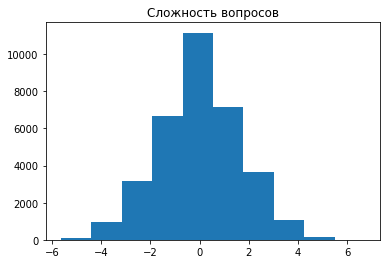

Средняя сложность вопроса: -7.965672555025364e-05


In [56]:
plt.hist(q)
plt.title('Сложность вопросов')
plt.show()
print(f'Средняя сложность вопроса: {np.mean(q)}')

"Средний" вопрос имеет сложность 0, найдем подобный вопрос из датасета

In [57]:
average_q = np.argmin(np.abs(q))
average_question = ohe_questions.transform([[average_q]])
print(f'Сложность вопроса {average_q}: {q[average_q]}, его и будем считать средним для удобства')

Сложность вопроса 12367: 0.0, его и будем считать средним для удобства


In [58]:
def calculate_metrics(model, tournaments=test_tournaments, result=results,
                        ohe_players=ohe_players,
                        ohe_questions=ohe_questions,
                        average_q=average_q):
    spearman_correlations = []
    kendall_correlations = []
    for i, idx in enumerate(tqdm.tqdm(tournaments.index)):
        prediction, ground_true = [], []
        for team in result[idx]:
            # Если по команде нет результата - то пропускаем
            if 'position' not in team:
                continue
            if 'mask' not in team:
                continue
            mask = team['mask']
            if mask is None:
                continue
    
            team_size = len(team['teamMembers'])
            # Если в команде нет игроков - пропускаем
            if team_size == 0:
                continue
            team_members = []
            for player in team['teamMembers']:
                # Пропускаем новых игроков, которых не было в train
                try:
                    ohe_players.transform([[player['player']['id']]])
                    team_members.append(player['player']['id'])
                except ValueError:
                    continue
            team_size = len(team_members)
            if team_size == 0:
                continue
                
            ground_true.append(team['position'])
            players_matrix = ohe_players.transform(np.array(team_members).reshape(-1, 1))
            question_matrix = ohe_questions.transform(np.full((team_size, 1), average_q))
            X = hstack([players_matrix, question_matrix])
            skill = model.predict_proba(X)[:, 1]
            team_rating = 1 - np.prod(1 - skill)
            prediction.append(-team_rating)
        if np.unique(ground_true).shape[0] == 1:
            continue
        spearman_corr = spearmanr(prediction, ground_true)[0]
        spearman_correlations.append(spearman_corr)
        kendall_corr = kendalltau(prediction, ground_true)[0]
        kendall_correlations.append(kendall_corr)
            
    spearman_corr = np.mean([t for t in spearman_correlations if np.isfinite(t)])
    kendall_corr = np.mean([t for t in kendall_correlations if np.isfinite(t)])
    return spearman_corr, kendall_corr

In [59]:
spearman_baseline_2, kendall_base_line_2 = calculate_metrics(baseline_2)
print(f'Корреляция Спирмена: {spearman_baseline_2:0.2f}')
print(f'Корреляция Кендалла: {kendall_base_line_2:0.2f}')

100%|██████████| 416/416 [02:27<00:00,  2.83it/s]

Корреляция Спирмена: 0.77
Корреляция Кендалла: 0.62


### E-шаг

In [60]:
def E_step(model, train_data=X,
           y = y,
           tournaments=train_tournaments,
           result=results,
           num_players=total_players,
           num_questions=total_questions):
    
    predictions = model.predict_proba(train_data)[:, 1]
    z = np.zeros(predictions.shape)   
    tournament_first_question_idx = 0
    current_idx = 0
    
    for idx in tqdm.tqdm(tournaments.index):
        if len(result[idx]) == 0:
            continue
        tournament_questions = tournaments.loc[idx].total_questions
        team_data = []
        for team in result[idx]:
            # Если по команде нет результата - то пропускаем
            if 'mask' not in team:
                continue
            mask = team['mask']
            if mask is None:
                continue

            # Убираем снятые вопросы (отмеченные 'Х')
            mask = np.array([1 if a=='1' else 0 for a in mask if a!='X'])

            team_size = len(team['teamMembers'])
            questions_qty = mask.shape[0]
            batch_size = team_size * questions_qty

            # Если в команде нет игроков - пропускаем
            if team_size == 0:
                continue

            # Ответы команды
            team_answers = predictions[current_idx: current_idx + batch_size]
            true_team_answers = y[current_idx: current_idx + questions_qty]
            
            # Приведем к виду матрицы где в каждой строке - ответы всей команды на вопрос
            
            team_answers = team_answers.reshape((-1, questions_qty)).T
            
            # Вычислим z по формуле из E-шага
            denominator = 1 - np.prod(1 - team_answers, axis=1)
            team_answers = team_answers / denominator.reshape(-1, 1)
            
            team_answers[true_team_answers==0, :] = 0
            
            predictions[current_idx: current_idx + batch_size] = team_answers.T.reshape(-1) 
            current_idx += batch_size
    return predictions

**16 gb оперативной памяти не хватает**

In [61]:
pd.to_pickle(baseline_2, 'baseline_2.pkl')

pd.to_pickle(X, 'X.pkl')
pd.to_pickle(train_tournaments, 'train_tournaments.pkl')

### M-шаг

Теперь нам нужно обучить параметры p, q, проблема в том, что у нас target (z) для логистической регрессии равен z и это вещественные числа от 0 до 1, а не метки классов.

Попробую следующий метод - для каждого z в обучающую выборку поместим по 2 строки с таргетами 0 и 1 и обучать будем с весами (1-z) и z соответственно.

In [62]:
X = pd.read_pickle('X.pkl')
baseline_2 = pd.read_pickle('baseline_2.pkl')
train_tournaments = pd.read_pickle('train_tournaments.pkl')

In [63]:
def M_step(z, train_data=X):
    y_0 = np.zeros((train_data.shape[0], 1))
    y_1 = np.ones((train_data.shape[0], 1))
    y = np.vstack([y_0, y_1]).reshape(-1)
    train_data = vstack([train_data, train_data])
    weights = np.concatenate([1 - z, z])
    model = LogisticRegression(verbose=1, solver='saga', n_jobs=-1)
    model.fit(train_data, y, sample_weight=weights)
    proba = model.predict_proba(train_data)[:, 1]
    return model, log_loss(proba, y, weights)

In [64]:
spearman_train, kendall_train = calculate_metrics(baseline_2, tournaments=train_tournaments)
spearman_test, kendall_test = calculate_metrics(baseline_2)
print('Baseline #2')
print(f'Корреляция Спирмена - train: {spearman_train:0.4f}')
print(f'Корреляция Кендалла - train: {kendall_train:0.4f}')
print(f'Корреляция Спирмена - test: {spearman_test:0.4f}')
print(f'Корреляция Кендалла - test: {kendall_test:0.4f}')

100%|██████████| 416/416 [02:25<00:00,  2.85it/s]

Baseline #2
Корреляция Спирмена - train: 0.8333
Корреляция Кендалла - train: 0.6828
Корреляция Спирмена - test: 0.7748
Корреляция Кендалла - test: 0.6161


In [65]:
pd.to_pickle(spearman_train, 'spearman_train.pkl')
pd.to_pickle(kendall_train, 'kendall_train.pkl')
pd.to_pickle(spearman_test, 'spearman_test.pkl')
pd.to_pickle(kendall_test, 'kendall_test.pkl')

**несколько итераций EM алгоритма и посмотрим на метрики на train и test**

In [66]:
spearman_train = [spearman_train]
spearman_test = [spearman_test]
kendall_train = [kendall_train]
kendall_test = [kendall_test]

best_metrics = np.mean([spearman_test, kendall_test])
best_em_model = baseline_2

model_m = baseline_2
for i in range(5):
    time.sleep(0.5)
    
    z = E_step(model=model_m)
    model_m, loss = M_step(z)
    
    spearman_corr_train, kendall_corr_train = calculate_metrics(model_m, tournaments=train_tournaments)
    spearman_corr_test, kendall_corr_test = calculate_metrics(model_m)
    spearman_train.append(spearman_corr_train)
    spearman_test.append(spearman_corr_test)
    kendall_train.append(kendall_corr_train)
    kendall_test.append(kendall_corr_test)
    
    print(f'После итерации {i + 1}')
    print(f'Корреляция Спирмена - train: {spearman_corr_train:0.4f}')
    print(f'Корреляция Кендалла - train: {kendall_corr_train:0.4f}')
    print(f'Корреляция Спирмена - test: {spearman_corr_test:0.4f}')
    print(f'Корреляция Кендалла - test: {kendall_corr_test:0.4f}')
    print(f'Log loss: {loss:0.4f}')
    
    if np.mean([spearman_corr_test, kendall_corr_test]) > best_metrics:
        best_em_model = model_m
        best_metrics = np.mean([spearman_corr_test, kendall_corr_test])

100%|██████████| 689/689 [00:02<00:00, 340.37it/s]
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 23 epochs took 556 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  9.3min finished
100%|██████████| 416/416 [02:24<00:00,  2.88it/s]


После итерации 1
Корреляция Спирмена - train: 0.8438
Корреляция Кендалла - train: 0.6944
Корреляция Спирмена - test: 0.7894
Корреляция Кендалла - test: 0.6323
Log loss: 0.3931


100%|██████████| 689/689 [00:02<00:00, 322.00it/s]
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 25 epochs took 605 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 10.1min finished
100%|██████████| 416/416 [02:26<00:00,  2.84it/s]


После итерации 2
Корреляция Спирмена - train: 0.8477
Корреляция Кендалла - train: 0.6991
Корреляция Спирмена - test: 0.7887
Корреляция Кендалла - test: 0.6323
Log loss: 0.3470


100%|██████████| 689/689 [00:02<00:00, 329.93it/s]
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 24 epochs took 581 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  9.7min finished
100%|██████████| 416/416 [02:26<00:00,  2.83it/s]


После итерации 3
Корреляция Спирмена - train: 0.8522
Корреляция Кендалла - train: 0.7046
Корреляция Спирмена - test: 0.7882
Корреляция Кендалла - test: 0.6316
Log loss: 0.3285


100%|██████████| 689/689 [00:02<00:00, 336.18it/s]
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 24 epochs took 585 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  9.8min finished
100%|██████████| 416/416 [02:25<00:00,  2.86it/s]


После итерации 4
Корреляция Спирмена - train: 0.8557
Корреляция Кендалла - train: 0.7090
Корреляция Спирмена - test: 0.7873
Корреляция Кендалла - test: 0.6310
Log loss: 0.3203


100%|██████████| 689/689 [00:02<00:00, 331.57it/s]
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 23 epochs took 558 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  9.3min finished
100%|██████████| 416/416 [02:24<00:00,  2.88it/s]

После итерации 5
Корреляция Спирмена - train: 0.8588
Корреляция Кендалла - train: 0.7129
Корреляция Спирмена - test: 0.7837
Корреляция Кендалла - test: 0.6268
Log loss: 0.3160


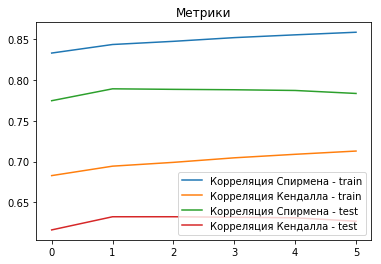

In [67]:
plt.plot(spearman_train, label='Корреляция Спирмена - train')
plt.plot(kendall_train, label='Корреляция Кендалла - train')
plt.plot(spearman_test, label='Корреляция Спирмена - test')
plt.plot(kendall_test, label='Корреляция Кендалла - test')
plt.legend()
plt.title('Метрики')
plt.show()

**метрики на train растут вместе с итерациями EM алгоритма, при этом метрики на test выросли только после первой итерации EM, эту модель и будем использовать дальше**

In [68]:
pd.to_pickle(best_em_model, 'best_em_model.pkl')
pd.to_pickle(ohe_questions, 'ohe_questions.pkl')
pd.to_pickle(ohe_players, 'ohe_players.pkl')

# 5. А что там с вопросами? 

In [69]:
p = best_em_model.coef_[0][:total_players] # уровень игрока
q = best_em_model.coef_[0][total_players:] # сложность вопроса

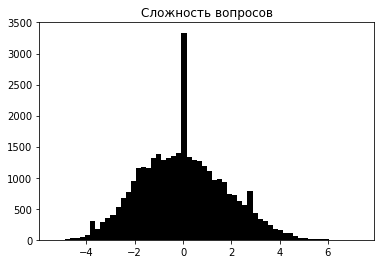

Средняя сложность вопроса: -0.00012719885674515577


In [70]:
plt.hist(q, bins=60, color='black')
plt.title('Сложность вопросов')
plt.show()
print(f'Средняя сложность вопроса: {np.mean(q)}')

In [71]:
tournaments_questions = {}
current_idx = 0
for idx in tqdm.tqdm(train_tournaments.index):
    tournament_questions = train_tournaments.loc[idx].total_questions
    for team in results[idx]:
        if 'mask' not in team:
            continue
        mask = team['mask']
        if mask is None:
            continue
        canceled = np.sum([1 if a=='X' else 0 for a in mask])
    tournaments_questions[idx] = q[current_idx:current_idx + (tournament_questions - canceled)]
    current_idx += (tournament_questions - canceled)

100%|██████████| 689/689 [00:00<00:00, 924.04it/s]


In [72]:
average_difficulty = {k: np.mean(v) for k, v in tournaments_questions.items()}

# Отсортируем по сложности

sorted_tournaments = sorted([(k, v) for k, v in average_difficulty.items()],
                            key= lambda x: x[1])

**Турниры с самыми сложными вопросами:**

In [73]:
for i, (k, v) in enumerate(sorted_tournaments[:10]):
    print(f'{i + 1}. {k}-{train_tournaments.loc[k, "name"]} - {v:0.3f}')

1. 5159-Первенство правого полушария - -2.216
2. 5025-Кубок городов - -1.983
3. 5464-Зимние игры - -1.873
4. 5794-Блаженный Августинер - -1.846
5. 5815-Гусарская лига. III сезон. II этап - -1.846
6. 5083-Ускользающая сова - -1.810
7. 5887-Я.Сова - -1.789
8. 5186-VERSUS: Коробейников vs. Матвеев - -1.675
9. 5671-Чемпионат Минска. Финал - -1.642
10. 5161-Антибинго - -1.639


**Турниры с самыми простыми вопросами:**

In [74]:
for i, (k, v) in enumerate(sorted_tournaments[:-10:-1]):
    print(f'{i + 1}. {k}-{train_tournaments.loc[k, "name"]} - {v:0.3f}')

1. 5807-Лига Сибири. II тур. - 2.694
2. 5795-Кубок Москвы - 2.591
3. 5013-(а)Синхрон-lite. Лига старта. Эпизод V - 2.511
4. 5797-Третья октава - 2.442
5. 5438-Синхрон Лиги Разума - 2.359
6. 5009-(а)Синхрон-lite. Лига старта. Эпизод III - 2.345
7. 5817-Симбирск-Open - 2.320
8. 5979-ТРИОтлон-4 - 2.252
9. 5457-Студенческий чемпионат Калининградской области - 2.201


**самый сложный и самый простой вопросы**

In [75]:
max_d = np.inf
min_d = -np.inf
max_tournament, min_tournament = None, None
max_num, min_num = None, None

for k, v in tournaments_questions.items():
    if np.min(v) <  max_d:
        max_d = np.min(v)
        max_tournament = k
        max_num = np.argmin(v)
        
    if np.max(v) >  min_d:
        min_d = np.max(v)
        min_tournament = k
        min_num = np.argmax(v)

In [76]:
print(f'Самый сложный вопрос имеет сложность {max_d:0.2f} был задан на турнире {max_tournament} {train_tournaments.loc[max_tournament, "name"]} под номером {max_num + 1} из {train_tournaments.loc[max_tournament, "total_questions"]}')
print(f'Самый простой вопрос имеет сложность {min_d:0.2f} был задан на турнире {min_tournament} {train_tournaments.loc[min_tournament, "name"]} под номером {min_num + 1} из {train_tournaments.loc[min_tournament, "total_questions"]}')

Самый сложный вопрос имеет сложность -5.32 был задан на турнире 5025 Кубок городов под номером 43 из 48
Самый простой вопрос имеет сложность 7.29 был задан на турнире 5681 [18+] Болтик в гаечку под номером 35 из 36


# 6. Бонус: постройте топ игроков по предсказанной вашей моделью силе игры, а рядом с именами игроков напишите общее число вопросов, которое они сыграли. 

In [77]:
from scipy import sparse
player_ids1 = ohe_players.inverse_transform(sparse.eye(len(p)))

In [78]:
players = pd.read_pickle('players.pkl')

In [79]:
players_skill = pd.DataFrame(np.concatenate([player_ids1, p.reshape(-1,1)], axis=1),
                             columns = ['id', 'skill'])
players_skill['id'] = players_skill['id'].astype(int)
players_skill = players_skill.set_index('id', drop=True)

# Добавим ФИО

players = pd.DataFrame(players.values()).set_index('id', drop=True)
players_skill = players_skill.merge(players, how='left', left_index=True, right_index=True)
players_skill.head()

,skill,name,patronymic,surname
id,,,,
15,0.623851,Олег,Игоревич,Абарников
16,1.851539,Азер,Абасали оглы,Абасалиев
23,0.998583,Андрей,Николаевич,Абащенко
31,0.886032,Ситара,Фахраддин гызы,Абасова
35,1.005976,Нарек,Гагикович,Абгарян


In [80]:
players_skill['total_questions'] = players_total_questions
players_skill.head()

,skill,name,patronymic,surname,total_questions
id,,,,,
15,0.623851,Олег,Игоревич,Абарников,560.0
16,1.851539,Азер,Абасали оглы,Абасалиев,234.0
23,0.998583,Андрей,Николаевич,Абащенко,36.0
31,0.886032,Ситара,Фахраддин гызы,Абасова,865.0
35,1.005976,Нарек,Гагикович,Абгарян,779.0


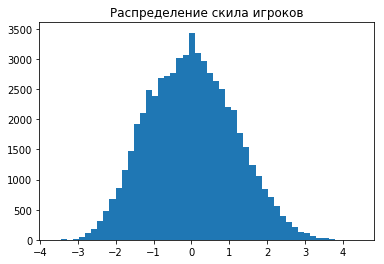

In [81]:
plt.hist(players_skill.skill, bins=50)
plt.title('Распределение скила игроков')
plt.show()

In [82]:
players_skill.sort_values('skill', ascending=False).head(10)

,skill,name,patronymic,surname,total_questions
id,,,,,
27403,4.426262,Максим,Михайлович,Руссо,2331.0
4270,4.251735,Александра,Владимировна,Брутер,2881.0
28751,4.232530,Иван,Николаевич,Семушин,3963.0
30152,4.034310,Артём,Сергеевич,Сорожкин,5083.0
27822,4.014491,Михаил,Владимирович,Савченков,3449.0
30270,3.989199,Сергей,Леонидович,Спешков,3962.0
20691,3.861099,Станислав,Григорьевич,Мереминский,1656.0
18036,3.836671,Михаил,Ильич,Левандовский,1502.0
26089,3.821937,Ирина,Сергеевна,Прокофьева,1112.0


In [83]:
players_skill.sort_values('skill', ascending=False).head(30)

,skill,name,patronymic,surname,total_questions
id,,,,,
27403,4.426262,Максим,Михайлович,Руссо,2331.0
4270,4.251735,Александра,Владимировна,Брутер,2881.0
28751,4.232530,Иван,Николаевич,Семушин,3963.0
30152,4.034310,Артём,Сергеевич,Сорожкин,5083.0
27822,4.014491,Михаил,Владимирович,Савченков,3449.0
30270,3.989199,Сергей,Леонидович,Спешков,3962.0
20691,3.861099,Станислав,Григорьевич,Мереминский,1656.0
18036,3.836671,Михаил,Ильич,Левандовский,1502.0
26089,3.821937,Ирина,Сергеевна,Прокофьева,1112.0


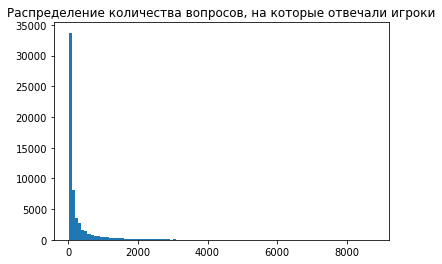

In [84]:
plt.hist(players_skill.total_questions, bins=100)
plt.title('Распределение количества вопросов, на которые отвечали игроки')
plt.show()

In [85]:
players_1000 = players_skill[players_skill.total_questions >= 1000].sort_values('skill', ascending=False)
print(f'Всего осталось {len(players_1000)} игроков из {len(players_skill)}')
players_1000.head(30)

Всего осталось 4672 игроков из 59271


,skill,name,patronymic,surname,total_questions
id,,,,,
27403,4.426262,Максим,Михайлович,Руссо,2331.0
4270,4.251735,Александра,Владимировна,Брутер,2881.0
28751,4.232530,Иван,Николаевич,Семушин,3963.0
30152,4.034310,Артём,Сергеевич,Сорожкин,5083.0
27822,4.014491,Михаил,Владимирович,Савченков,3449.0
30270,3.989199,Сергей,Леонидович,Спешков,3962.0
20691,3.861099,Станислав,Григорьевич,Мереминский,1656.0
18036,3.836671,Михаил,Ильич,Левандовский,1502.0
26089,3.821937,Ирина,Сергеевна,Прокофьева,1112.0


In [86]:
def sigmoid(x):
    x = 1.0 / (1.0 + np.exp(-1.0 * x))
    return x

def rating_adjustment(x):
    t = x / 100 - 5
    return sigmoid(t)

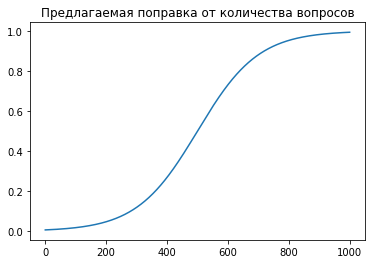

In [87]:
x = np.linspace(-0, 1000, 1000)
plt.plot(x, rating_adjustment(x))
plt.title('Предлагаемая поправка от количества вопросов')
plt.show()

In [88]:
def adjust_rating(x):
    if x.total_questions > 1000:
        return x.skill_positive
    return x.skill_positive * rating_adjustment(x.total_questions)

In [89]:
min_skill = players_skill.skill.min()
players_skill['skill_positive'] = players_skill.skill - min_skill
players_skill['adjusted_skill'] = players_skill.apply(adjust_rating, axis=1) + min_skill

In [90]:
players_adjusted = players_skill.sort_values('adjusted_skill', ascending=False)
players_adjusted.head(30)

,skill,name,patronymic,surname,total_questions,skill_positive,adjusted_skill
id,,,,,,,
27403,4.426262,Максим,Михайлович,Руссо,2331.0,8.038919,4.426262
4270,4.251735,Александра,Владимировна,Брутер,2881.0,7.864393,4.251735
28751,4.232530,Иван,Николаевич,Семушин,3963.0,7.845187,4.232530
30152,4.034310,Артём,Сергеевич,Сорожкин,5083.0,7.646968,4.034310
27822,4.014491,Михаил,Владимирович,Савченков,3449.0,7.627149,4.014491
30270,3.989199,Сергей,Леонидович,Спешков,3962.0,7.601857,3.989199
20691,3.861099,Станислав,Григорьевич,Мереминский,1656.0,7.473757,3.861099
18036,3.836671,Михаил,Ильич,Левандовский,1502.0,7.449328,3.836671
26089,3.821937,Ирина,Сергеевна,Прокофьева,1112.0,7.434595,3.821937


In [91]:
# Загружаем лучшую модель
adjusted_model = pd.read_pickle('best_em_model.pkl')
# Меняем в ней коэффициенты, отвечающие за скилл
ordered_players = ohe_players.inverse_transform(sparse.eye(len(p)))
adjusted_model.coef_[:, :len(ordered_players)] = players_adjusted.loc[ordered_players.reshape(-1)].adjusted_skill.values.reshape(1,-1)

In [92]:
spearman_corr_adjusted, kendall_corr_adjusted = calculate_metrics(adjusted_model)

100%|██████████| 416/416 [02:27<00:00,  2.82it/s]


In [93]:
print('Adjusted model')
print(f'Корреляция Спирмена - test: {spearman_corr_adjusted:0.4f}')
print(f'Корреляция Кендалла - test: {kendall_corr_adjusted:0.4f}')

Adjusted model
Корреляция Спирмена - test: 0.7021
Корреляция Кендалла - test: 0.5517
